<a href="https://colab.research.google.com/github/pstjohn/gnn-codecamp/blob/main/cetane_number_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Enabling the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

In [1]:
!pip install rdkit-pypi

In [2]:
import numpy as np
import pandas as pd

import rdkit
from rdkit.Chem import AllChem

In [3]:
cn_data = pd.read_csv('https://raw.githubusercontent.com/pstjohn/gnn-codecamp/main/cn.csv')
cn_data.head()

,SMILES,IUPAC name,CN,Device
0,CCCCCCC,heptane,57.600,AFIDA
1,CCCCCCCCCCCCO,dodecan-1-ol,51.605,AFIDA
2,CCCC=O,butanal,38.315,AFIDA
3,CC1CCCCC1,methylcyclohexane,17.355,AFIDA
4,CC(C)CC(C)(C)C,"2,2,4-trimethylpentane",5.200,AFIDA


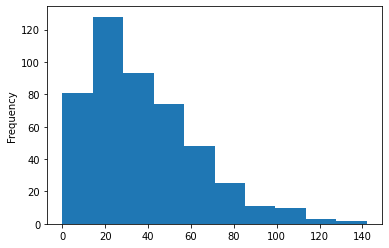

In [4]:
cn_data.CN.plot.hist()

In [5]:
cn_data['CN'] = cn_data.CN.clip(upper=100)

In [6]:
cn_test = cn_data.sample(frac=0.2, random_state=42)
cn_train = cn_data[~cn_data.index.isin(cn_test.index)]

In [7]:
def get_morgan_fingerprint(smiles, radius=2, nBits=1024):
  mol = rdkit.Chem.MolFromSmiles(smiles)
  bv = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
  return np.asarray(bv)

def get_all_fingerprints(smiles_series):
  fingerprints = np.vstack(smiles_series.apply(get_morgan_fingerprint).values)
  return fingerprints

In [8]:
fingerprints_train = get_all_fingerprints(cn_train.SMILES)
fingerprints_test = get_all_fingerprints(cn_test.SMILES)

In [9]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.5.0'

In [10]:
input = layers.Input(shape=(1024), name='fingerprint', dtype='int64')
out = layers.Dense(128, activation='relu')(input)
out = layers.BatchNormalization()(out)
out = layers.Dense(64, activation='relu')(out)
out = layers.BatchNormalization()(out)
out = layers.Dense(1)(out)

mlp_model = tf.keras.Model(input, out)

In [11]:
opt = tf.keras.optimizers.Adam(learning_rate=1E-2)
mlp_model.compile(optimizer=opt, loss='mae')

In [12]:
hist = mlp_model.fit(x=fingerprints_train, y=cn_train.CN,
                     validation_data=(fingerprints_test, cn_test.CN),
                     epochs=30, batch_size=32, verbose=2)

Epoch 1/30
12/12 - 1s - loss: 36.3798 - val_loss: 37.2450
Epoch 2/30
12/12 - 0s - loss: 33.3452 - val_loss: 26.9556
Epoch 3/30
12/12 - 0s - loss: 27.9581 - val_loss: 16.2326
Epoch 4/30
12/12 - 0s - loss: 20.2867 - val_loss: 17.1705
Epoch 5/30
12/12 - 0s - loss: 12.7326 - val_loss: 27.5850
Epoch 6/30
12/12 - 0s - loss: 10.3729 - val_loss: 24.3668
Epoch 7/30
12/12 - 0s - loss: 8.4761 - val_loss: 15.3061
Epoch 8/30
12/12 - 0s - loss: 8.3823 - val_loss: 21.3305
Epoch 9/30
12/12 - 0s - loss: 7.3135 - val_loss: 16.0715
Epoch 10/30
12/12 - 0s - loss: 7.2686 - val_loss: 15.4526
Epoch 11/30
12/12 - 0s - loss: 6.9520 - val_loss: 13.8154
Epoch 12/30
12/12 - 0s - loss: 6.2418 - val_loss: 15.3910
Epoch 13/30
12/12 - 0s - loss: 7.0955 - val_loss: 12.3067
Epoch 14/30
12/12 - 0s - loss: 6.2247 - val_loss: 12.8394
Epoch 15/30
12/12 - 0s - loss: 6.9643 - val_loss: 10.6590
Epoch 16/30
12/12 - 0s - loss: 6.3129 - val_loss: 11.6935
Epoch 17/30
12/12 - 0s - loss: 5.9140 - val_loss: 12.5335
Epoch 18/30
12/12

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

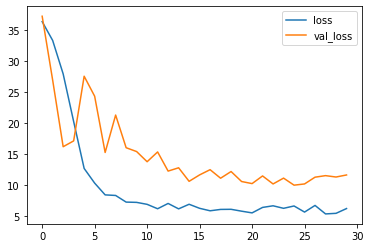

In [14]:
pd.DataFrame(hist.history).plot.line()

In [15]:
mlp_model.predict(get_morgan_fingerprint('CC(C)COCC(C)C').reshape(1, -1))

array([[71.30717]], dtype=float32)

In [16]:
!pip install nfp

In [17]:
import nfp
from collections import namedtuple

atom_type = namedtuple('Atom', ['symbol', 'aromatic', 'ring_size', 'degree', 'totalHs'])
bond_type = namedtuple('Bond', ['bond_type', 'degree', 'ring_size'])

def atom_featurizer(atom):
    """ Return an string representing the atom type
    """

    return atom_type(
        atom.GetSymbol(),
        atom.GetIsAromatic(),
        nfp.get_ring_size(atom, max_size=6),
        atom.GetDegree(),
        atom.GetTotalNumHs(includeNeighbors=True)
    )

def bond_featurizer(bond, flipped=False):
    """ Get a similar classification of the bond type.
    Flipped indicates which 'direction' the bond edge is pointing. """
    
    if not flipped:
        atoms = "{}-{}".format(
            *tuple((bond.GetBeginAtom().GetSymbol(),
                    bond.GetEndAtom().GetSymbol())))
    else:
        atoms = "{}-{}".format(
            *tuple((bond.GetEndAtom().GetSymbol(),
                    bond.GetBeginAtom().GetSymbol())))
    
    btype = str(bond.GetBondType())
    ring = nfp.get_ring_size(bond, max_size=6) if bond.IsInRing() else None
    
    return bond_type(atoms, btype, ring)

In [18]:
mol = rdkit.Chem.MolFromSmiles('CC(C)COCC(C)C')

In [19]:
atom_featurizer(mol.GetAtoms()[0])

Atom(symbol='C', aromatic=False, ring_size=0, degree=1, totalHs=3)

In [20]:
bond_featurizer(mol.GetBonds()[0])

Bond(bond_type='C-C', degree='SINGLE', ring_size=None)

In [21]:
preprocessor = nfp.SmilesPreprocessor(atom_features=atom_featurizer,
                                      bond_features=bond_featurizer,
                                      explicit_hs=False)

In [22]:
pd.Series(preprocessor.atom_tokenizer._data)

unk    1
dtype: int64

In [23]:
for smiles in cn_train.SMILES: 
  preprocessor.construct_feature_matrices(smiles, train=True)

In [24]:
pd.Series(preprocessor.atom_tokenizer._data)

unk                       1
(C, False, 0, 1, 3)       2
(C, False, 0, 2, 2)       3
(O, False, 0, 1, 1)       4
(C, False, 0, 2, 1)       5
(O, False, 0, 1, 0)       6
(C, False, max, 3, 1)     7
(C, False, max, 2, 2)     8
(C, False, 0, 3, 1)       9
(C, False, 0, 4, 0)      10
(O, False, 0, 2, 0)      11
(C, False, 0, 3, 0)      12
(C, False, 4, 4, 0)      13
(C, False, 4, 2, 2)      14
(O, False, 4, 2, 0)      15
(C, False, 0, 1, 2)      16
(C, False, 5, 2, 2)      17
(C, False, max, 2, 1)    18
(C, True, max, 3, 0)     19
(C, True, max, 2, 1)     20
(C, True, 5, 3, 0)       21
(C, False, 5, 3, 1)      22
(O, False, 5, 2, 0)      23
(C, True, 5, 2, 1)       24
(O, True, 5, 2, 0)       25
(C, False, max, 3, 0)    26
(C, False, 4, 3, 1)      27
(O, False, max, 2, 0)    28
(C, False, max, 4, 0)    29
(C, False, 0, 1, 1)      30
(C, False, 0, 2, 0)      31
(C, False, 3, 3, 1)      32
(C, False, 3, 4, 0)      33
(C, False, 5, 3, 0)      34
(C, False, 5, 2, 1)      35
(C, False, 5, 4, 0) 

In [25]:
preprocessor.construct_feature_matrices('CCO', train=False)['atom']

array([2, 3, 4], dtype=int32)

In [26]:
preprocessor.construct_feature_matrices('CCO', train=False)['bond']

array([2, 2, 3, 4], dtype=int32)

In [27]:
preprocessor.construct_feature_matrices('CCO', train=False)['connectivity']

array([[0, 1],
       [1, 0],
       [1, 2],
       [2, 1]], dtype=int32)

In [28]:
def data_generator(cn_split):
  for _, row in cn_split.iterrows():
    inputs = preprocessor.construct_feature_matrices(row.SMILES, train=False)
    yield ({'atom': inputs['atom'],
            'bond': inputs['bond'],
            'connectivity': inputs['connectivity']},
           row.CN)

output_signature = (preprocessor.output_signature,
                    tf.TensorSpec(shape=(), dtype=tf.float32))

In [29]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(cn_train),
    output_signature=output_signature)\
    .cache().shuffle(buffer_size=200)\
    .padded_batch(batch_size=32)\
    .prefetch(tf.data.experimental.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(cn_test),
    output_signature=output_signature)\
    .cache().shuffle(buffer_size=200)\
    .padded_batch(batch_size=32)\
    .prefetch(tf.data.experimental.AUTOTUNE)

In [30]:
for inputs, outputs in train_dataset.as_numpy_iterator():
  break

inputs['atom']

array([[ 2,  3,  3,  3,  3,  5,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 2,  3,  9,  2,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 2,  3,  3,  3,  3,  3,  3,  3, 11, 12,  2,  6,  0,  0,  0,  0,
         0,  0],
       [ 2,  3,  3,  9,  2,  3,  3,  3,  9,  2,  3,  3,  3,  9,  2,  2,
         0,  0],
       [ 2,  3,  3,  3,  3,  9,  2,  4,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 2,  3,  3,  3,  3, 11,  3,  3,  3,  3,  2,  0,  0,  0,  0,  0,
         0,  0],
       [35, 35, 23, 17, 17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 2,  3,  3,  3,  3, 29,  8,  7,  8,  7,  8,  7,  8,  8,  8,  0,
         0,  0],
       [24, 24, 24, 25, 24,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 2,  3,  3,  3,  3,  3, 11,  2,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 2, 10,  2,  2,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 2,  3,  3,  

In [31]:
outputs

array([ 75.2      ,   8.14     ,  44.405    ,  60.85     ,  24.65     ,
       100.       ,  20.       ,  48.5      ,   7.       ,  99.8      ,
         8.11     ,  36.6      ,  13.7      ,  20.4      ,  75.9      ,
        49.36     ,   2.128    , 100.       ,  32.2      ,   3.8668349,
        24.4      ,   6.19     ,  10.2      , 100.       ,   9.8      ,
        52.6      ,  16.3      ,   7.6      ,  12.92     ,   6.       ,
        38.2      ,  35.8      ], dtype=float32)

In [32]:
atom = layers.Input(shape=[None], dtype=tf.int32, name='atom')
bond = layers.Input(shape=[None], dtype=tf.int32, name='bond')
connectivity = layers.Input(shape=[None, 2], dtype=tf.int32, name='connectivity')


num_features = 128

atom_state = layers.Embedding(preprocessor.atom_classes, num_features,
                              name='atom_embedding', mask_zero=True)(atom)

bond_state = layers.Embedding(preprocessor.bond_classes, num_features,
                              name='bond_embedding', mask_zero=True)(bond)

atom_mean = layers.Embedding(preprocessor.atom_classes, 1,
                             name='atom_mean', mask_zero=True)(atom)

for _ in range(6):
  new_bond_state = nfp.EdgeUpdate()([atom_state, bond_state, connectivity])
  bond_state = layers.Add()([bond_state, new_bond_state])

  new_atom_state = nfp.NodeUpdate()([atom_state, bond_state, connectivity])
  atom_state = layers.Add()([atom_state, new_atom_state])

atomwise_prediction = layers.Dense(1)(atom_state)
atomwise_prediction = layers.Add()([atomwise_prediction, atom_mean])
mol_prediction = layers.GlobalAveragePooling1D()(atomwise_prediction)

gnn_model = tf.keras.Model([atom, bond, connectivity], [mol_prediction])

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [33]:
!pip install -U tensorflow-addons
import tensorflow_addons as tfa

In [34]:
optimizer = tfa.optimizers.AdamW(learning_rate=1E-4, weight_decay=1E-5)
gnn_model.compile(optimizer, loss='mae')

In [35]:
hist = gnn_model.fit(train_dataset, validation_data=valid_dataset, epochs=50, verbose=2)

Epoch 1/50
12/12 - 11s - loss: 28.4258 - val_loss: 24.2220
Epoch 2/50
12/12 - 1s - loss: 17.4953 - val_loss: 15.5390
Epoch 3/50
12/12 - 1s - loss: 13.6884 - val_loss: 13.3456
Epoch 4/50
12/12 - 1s - loss: 12.3723 - val_loss: 12.0335
Epoch 5/50
12/12 - 1s - loss: 11.7753 - val_loss: 11.6641
Epoch 6/50
12/12 - 1s - loss: 10.8923 - val_loss: 10.2497
Epoch 7/50
12/12 - 1s - loss: 10.1548 - val_loss: 10.2058
Epoch 8/50
12/12 - 1s - loss: 10.3766 - val_loss: 10.7894
Epoch 9/50
12/12 - 1s - loss: 9.8212 - val_loss: 9.3480
Epoch 10/50
12/12 - 1s - loss: 9.1468 - val_loss: 9.4970
Epoch 11/50
12/12 - 1s - loss: 8.4980 - val_loss: 8.4363
Epoch 12/50
12/12 - 1s - loss: 8.4198 - val_loss: 9.1814
Epoch 13/50
12/12 - 1s - loss: 8.3321 - val_loss: 8.8189
Epoch 14/50
12/12 - 1s - loss: 8.6451 - val_loss: 9.5683
Epoch 15/50
12/12 - 1s - loss: 7.8693 - val_loss: 9.0818
Epoch 16/50
12/12 - 1s - loss: 8.0211 - val_loss: 8.7345
Epoch 17/50
12/12 - 1s - loss: 7.4076 - val_loss: 8.4737
Epoch 18/50
12/12 - 1s 

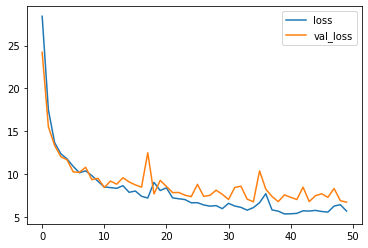

In [36]:
pd.DataFrame(hist.history).plot.line()

In [37]:
np.expand_dims(inputs['connectivity'], axis=0).shape

(1, 32, 34, 2)

In [38]:
inputs = preprocessor.construct_feature_matrices('CC(C)COCC(C)C')
gnn_model.predict({key: np.expand_dims(inputs[key], axis=0) for key in ['atom', 'bond', 'connectivity']})

array([[65.959076]], dtype=float32)

In [39]:
# https://doi.org/10.3929/ethz-b-000230799
! wget https://www.research-collection.ethz.ch/bitstream/handle/20.500.11850/230799/ChEMBL_eps_78.tar.gz 
! tar -xzf *.tar.gz

--2021-08-04 20:58:35--  https://www.research-collection.ethz.ch/bitstream/handle/20.500.11850/230799/ChEMBL_eps_78.tar.gz
Resolving www.research-collection.ethz.ch (www.research-collection.ethz.ch)... 129.132.8.151
Connecting to www.research-collection.ethz.ch (www.research-collection.ethz.ch)|129.132.8.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32743757 (31M) [application/octet-stream]
Saving to: ‘ChEMBL_eps_78.tar.gz.1’

ChEMBL_eps_78.tar.g 100%[===================>]  31.23M  10.2MB/s    in 3.2s    

2021-08-04 20:58:39 (9.71 MB/s) - ‘ChEMBL_eps_78.tar.gz.1’ saved [32743757/32743757]



In [40]:
import os

In [41]:
to_read = os.listdir('ChEMBL_mols')
from sklearn.model_selection import train_test_split

In [42]:
len(to_read)

40019

In [43]:
train_files, test_files = train_test_split(to_read, test_size=0.2)

In [44]:
def iter_mols(filenames):
  for filename in filenames:
    for mol in rdkit.Chem.SDMolSupplier(os.path.join('ChEMBL_mols', filename)):
      yield mol

In [45]:
def get_charges(mol):
  return np.array([float(a.GetProp('molFileAlias')) for a in mol.GetAtoms()])

In [46]:
mol = next(iter_mols(train_files))

In [47]:
get_charges(mol)

array([ 1.131587, -0.675413, -0.405496, -0.078475, -0.367145, -0.086738,
       -0.088578, -0.405332, -0.174874, -0.060825, -0.045239,  0.17867 ,
       -0.272097, -0.087974, -0.180094, -0.067529, -0.094017, -0.12947 ])

In [48]:
import random
from tqdm import tqdm

preprocessor = nfp.MolPreprocessor(atom_features=atom_featurizer,
                                   bond_features=bond_featurizer)

for mol in tqdm(iter_mols(random.sample(train_files, k=5000))):
  preprocessor.construct_feature_matrices(mol, train=True)

5000it [00:09, 550.05it/s]


In [49]:
def charges_data_generator(files):
  for mol in iter_mols(files):
    yield preprocessor.construct_feature_matrices(mol), get_charges(mol)

output_signature = (preprocessor.output_signature,
                    tf.TensorSpec(shape=(None,), dtype=tf.float32))

In [50]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: charges_data_generator(train_files),
    output_signature=output_signature)\
    .cache().repeat().shuffle(buffer_size=1000)\
    .padded_batch(batch_size=128, padding_values=({'atom': 0, 'bond': 0, 'connectivity': 0}, np.nan))\
    .prefetch(tf.data.experimental.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_generator(
    lambda: charges_data_generator(test_files),
    output_signature=output_signature)\
    .cache().repeat().shuffle(buffer_size=500)\
    .padded_batch(batch_size=32, padding_values=({'atom': 0, 'bond': 0, 'connectivity': 0}, np.nan))\
    .prefetch(tf.data.experimental.AUTOTUNE)

In [51]:
atom = layers.Input(shape=[None], dtype=tf.int32, name='atom')
bond = layers.Input(shape=[None], dtype=tf.int32, name='bond')
connectivity = layers.Input(shape=[None, 2], dtype=tf.int32, name='connectivity')


num_features = 128

atom_state = layers.Embedding(preprocessor.atom_classes, num_features,
                              name='atom_embedding', mask_zero=True)(atom)

bond_state = layers.Embedding(preprocessor.bond_classes, num_features,
                              name='bond_embedding', mask_zero=True)(bond)

atom_mean = layers.Embedding(preprocessor.atom_classes, 1,
                             name='atom_mean', mask_zero=True)(atom)

for _ in range(6):
  new_bond_state = nfp.EdgeUpdate()([atom_state, bond_state, connectivity])
  bond_state = layers.Add()([bond_state, new_bond_state])

  new_atom_state = nfp.NodeUpdate()([atom_state, bond_state, connectivity])
  atom_state = layers.Add()([atom_state, new_atom_state])

atomwise_prediction = layers.Dense(1)(atom_state)
atomwise_prediction = layers.Add()([atomwise_prediction, atom_mean])

charge_model = tf.keras.Model([atom, bond, connectivity], [atomwise_prediction])
optimizer = tfa.optimizers.AdamW(learning_rate=1E-4, weight_decay=1E-5)
charge_model.compile(optimizer, loss=nfp.losses.masked_mean_absolute_error)

In [52]:
charge_model.fit(train_dataset, validation_data=valid_dataset,
                 steps_per_epoch=100, validation_steps=10, epochs=10)

Epoch 1/10
100/100 [==============================] - 52s 417ms/step - loss: 0.0748 - val_loss: 0.0277
Epoch 2/10
100/100 [==============================] - 39s 390ms/step - loss: 0.0234 - val_loss: 0.0210
Epoch 3/10
100/100 [==============================] - 20s 205ms/step - loss: 0.0199 - val_loss: 0.0188
Epoch 4/10
100/100 [==============================] - 8s 77ms/step - loss: 0.0177 - val_loss: 0.0171
Epoch 5/10
100/100 [==============================] - 8s 79ms/step - loss: 0.0164 - val_loss: 0.0162
Epoch 6/10
100/100 [==============================] - 8s 78ms/step - loss: 0.0150 - val_loss: 0.0151
Epoch 7/10
100/100 [==============================] - 8s 77ms/step - loss: 0.0145 - val_loss: 0.0164
Epoch 8/10
100/100 [==============================] - 8s 77ms/step - loss: 0.0144 - val_loss: 0.0146
Epoch 9/10
100/100 [==============================] - 8s 81ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 10/10
100/100 [==============================] - 8s 81ms/step - loss: 0.0129 - 

In [53]:
from datetime import datetime
charge_model.save(f"{datetime.today().strftime('%Y%m%d')}_charge_model", include_optimizer=False)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: 20210804_charge_model/assets


INFO:tensorflow:Assets written to: 20210804_charge_model/assets
